In [1]:
import sys,time
sys.path.append('../')
from smodels.experiment.defaultFinalStates import finalStates
from smodels.share.models.mssm import BSMList
from smodels.share.models.SMparticles import SMList
from smodels.theory.theorySMS import TheorySMS
from smodels.experiment.expSMS import ExpSMS
from smodels.theory.model import Model
from smodels.tools.physicsUnits import fb, GeV, TeV, pb
from smodels.experiment.txnameObj import TxName, TxNameData
from smodels.experiment.infoObj import Info
import numpy as np
import unum

In [2]:
filePath = '../test/database/13TeV/CMS/CMS-PAS-SUS-15-002/data/T1.txt'
globalInfo = Info('../test/database/13TeV/CMS/CMS-PAS-SUS-15-002/globalInfo.txt')
infoObj = Info('../test/database/13TeV/CMS/CMS-PAS-SUS-15-002/data/dataInfo.txt')
databaseParticles = finalStates
tx = TxName(filePath,globalInfo,infoObj,databaseParticles)

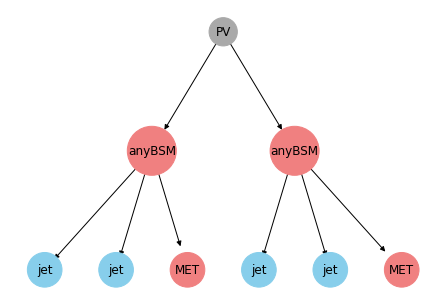

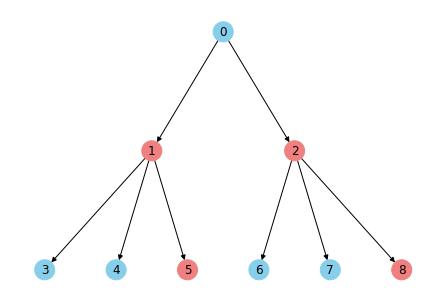

[(PV, 0), (anyBSM, 1), (anyBSM, 2), (jet, 3), (jet, 4), (MET, 5), (jet, 6), (jet, 7), (MET, 8)]


In [3]:
el = list(tx.smsMap.keys())[0]
el.draw()
el.draw(labelAttr='node')
print([(node,n) for node,n in zip(el.nodes,el.nodeIndices)])

In [4]:
for k in sorted(tx.dataMap.keys()):
    print(k,tx.dataMap[k])

0 (1, 'mass', 1.00E+00 [GeV])
1 (5, 'mass', 1.00E+00 [GeV])
2 (2, 'mass', 1.00E+00 [GeV])
3 (8, 'mass', 1.00E+00 [GeV])


In [5]:
for k in sorted(tx.arrayMap.keys()):
    print(k,tx.arrayMap[k])

0 ((0, 0, 0), 'mass', 1.00E+00 [GeV], 1)
1 ((0, 1, 0), 'mass', 1.00E+00 [GeV], 5)
2 ((1, 0, 0), 'mass', 1.00E+00 [GeV], 2)
3 ((1, 1, 0), 'mass', 1.00E+00 [GeV], 8)


In [6]:
print(tx.y_unit)

1.00E+00 [fb]


In [7]:
massPoint = [[100*GeV,50*GeV],[0.2*TeV,10*GeV]]
print(tx.transformPoint(massPoint))

[100.0, 50.0, 200.0, 10.0]


In [8]:
data = [ [[[100*GeV,50*GeV],[200*GeV,10*GeV]],0.1*fb],  [[[400*GeV,150*GeV],[300*GeV,30*GeV]],10.*pb]]
xvalues,yvalues = tx.transformData(data)
for ix,x in enumerate(xvalues):
    print(x,yvalues[ix])

[100.  50. 200.  10.] 0.1
[400. 150. 300.  30.] 10000.0


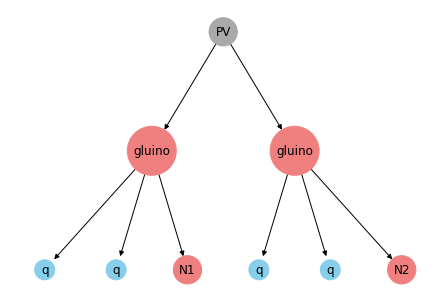

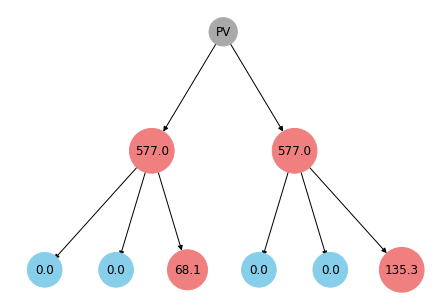

[None, 5.77E+02 [GeV], 5.77E+02 [GeV], 0.00E+00 [MeV], 0.00E+00 [MeV], 6.81E+01 [GeV], 0.00E+00 [MeV], 0.00E+00 [MeV], 1.35E+02 [GeV]]


In [9]:
slhafile="../inputFiles/slha/lightEWinos.slha"
model = Model(BSMList,SMList)
model.updateParticles(inputFile=slhafile,promptWidth = 1e-12*GeV)
expSMS = ExpSMS.from_string("[[['u','u~']],[['d','d~']]]",model=model,
             intermediateState=[['gluino'],['gluino']],finalState=['N1','N2'])
# Hack to create a theory element from a string:
treeA = TheorySMS()
treeA.add_nodes_from(expSMS.nodes)
treeA.add_edges_from(expSMS.edgeIndices)
treeA.prodXSec = 1.0*fb
treeA.maxWeight = 1.0*fb
treeA.setGlobalProperties()


elMatch = el.matchesTo(treeA)
elMatch.draw()
elMatch.draw(labelAttr='mass',attrUnit=GeV)
print(elMatch.mass)

In [10]:
elementData = tx.getDataFromSMS(elMatch)
print(elementData)
v = tx.txnameData.getValueFor(elementData)
print(v)
reweigtF = tx.getReweightingFor(elMatch)
print(reweigtF)

[577.0, 68.1, 577.0, 135.3]
None
None


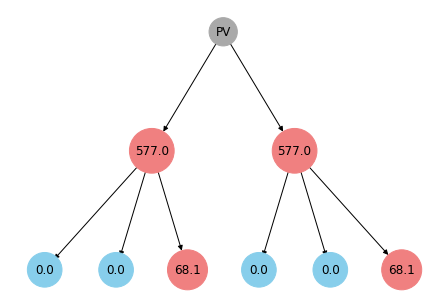

[None, 5.77E+02 [GeV], 5.77E+02 [GeV], 0.00E+00 [MeV], 0.00E+00 [MeV], 6.81E+01 [GeV], 0.00E+00 [MeV], 0.00E+00 [MeV], 6.81E+01 [GeV]]


In [11]:
expSMS = ExpSMS.from_string("[[['u','u~']],[['d','d~']]]",model=model,
             intermediateState=[['gluino'],['gluino']],finalState=['N1','N1'])
# Hack to create a theory element from a string:
elB = TheorySMS()
elB.add_nodes_from(expSMS.nodes)
elB.add_edges_from(expSMS.edgeIndices)
elB.prodXSec = 1.0*fb
elB.maxWeight = 1.0*fb
elB.setGlobalProperties()

elMatch = el.matchesTo(elB)
elMatch.draw(labelAttr='mass',attrUnit=GeV)
print(elMatch.mass)

In [12]:
elementData = tx.getDataFromSMS(elMatch)
print(elementData)
v = tx.txnameData.getValueFor(elementData)
print(v)
reweigtF = tx.getReweightingFor(elMatch)
print(reweigtF)

[577.0, 68.1, 577.0, 68.1]
None
1.0


In [13]:
elementData = [650.,203.,650.,203.]
v = tx.txnameData.getValueFor(elementData)
print(np.round(v,3),'(expected  ~ 196)') # expected ~ 196
# Change gluino and neutralino masses to get a result:
gluino = model.getParticlesWith(label='gluino')[0]
N1 = model.getParticlesWith(label='N1')[0]
gluino.mass = 650*GeV
N1.mass = 203*GeV
v = tx.getULFor(elMatch)
print(v)

195.808 (expected  ~ 196)
1.96E+02 [fb]


In [14]:
p = tx.txnameData.PCAtransf(elementData)
# print(p)
pInv = tx.txnameData.inversePCAtransf(p)
pInv = [tx.txnameData.round_to_n(x,5) for x in pInv[:]]
print(pInv)
print(pInv == elementData)

[650.0, 203.0, 650.0, 203.0]
True


In [15]:
print(tx.inverseTransformPoint(elementData))

[[6.50E+02 [GeV], 2.03E+02 [GeV]], [6.50E+02 [GeV], 2.03E+02 [GeV]]]


In [16]:
# Check reweighting
# Change gluino and neutralino widths:
gluino.totalwidth = 1e-13*GeV
N1.totalwidth = 1e-20*GeV
Leff_inner = 0.000769
Leff_outer = 7.0
hc = 197.327*1e-18
Flong = (np.exp(-N1.totalwidth.asNumber(GeV)*Leff_outer/hc))**2
Fprompt = (1. - np.exp(-gluino.totalwidth.asNumber(GeV)*Leff_inner/hc))**2
rFexp = 1/(Flong*Fprompt)
rF = tx.getReweightingFor(elMatch)
print(np.round(rF,4),'(expected ~ %1.2f)' %rFexp)
ul = tx.getULFor(elMatch)
print(ul,'(expected 195*9.6 ~1870)')

9.607 (expected ~ 9.61)
1.88E+03 [fb] (expected 195*9.6 ~1870)
